# Mental Health

**What did i do:**

- Clean, reproducible code cells with comments
- Matplotlib-only visualizations
- Robust preprocessing using sklearn pipelines
- Baseline models: Logistic Regression, Random Forest, Gradient Boosting
- Cross-validation, holdout test evaluation, ROC curves, confusion matrices
- Permutation feature importance


In [1]:
# Imports and configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve,
                             precision_recall_fscore_support, accuracy_score)
from sklearn.inspection import permutation_importance

print('libraries loaded')

libraries loaded


In [3]:
# Load dataset and quick inspect
DATA_PATH = 'mental_health_data_v2.csv'
df = pd.read_csv(DATA_PATH)

# Drop Risk_Probability column if present (user requested)
if 'Risk_Probability' in df.columns:
    df = df.drop(columns=['Risk_Probability'])

print('Rows, columns:', df.shape)
df.head()

Rows, columns: (40000, 23)


,Age,Gender,Employment_Status,Marital_Status,Work_Hours_per_Week,Financial_Stress,Physical_Activity_Hours_per_Week,Screen_Time_per_Day_hours,Sleep_Hours_per_Night,Alcohol_Units_per_Week,...,Support_System_Score,Stress_Level_Score,Rumination_Score,Feeling_Nervous,Trouble_Concentrating,Hopelessness,Avoids_People,Nightmares,Medication_Usage,Mental_Illness
0,16,Female,Retired,Married,0.0,2.77,1.24,2.86,6.76,1,...,4.30,4.53,4.15,0,0,0,0,0,0,No
1,47,Female,Employed,Single,54.7,2.99,2.11,3.72,7.68,2,...,5.20,4.80,3.81,1,0,0,0,0,0,No
2,32,Female,Employed,Single,42.1,5.61,2.94,1.34,6.12,1,...,4.29,3.77,0.21,0,0,0,0,0,0,No
3,22,Male,Employed,Widowed,45.2,0.54,3.76,7.87,7.38,1,...,5.94,5.63,5.60,0,0,0,0,0,0,No
4,24,Female,Student,Married,28.4,2.66,5.28,8.11,5.43,0,...,4.29,1.87,3.32,0,0,0,0,0,0,No


In [4]:
# EDA: class distribution, missingness, basic stats
print('Target distribution:')
print(df['Mental_Illness'].value_counts())
print('\nProportions:')
print(df['Mental_Illness'].value_counts(normalize=True))

# Missingness
missing = df.isnull().mean().sort_values(ascending=False)
print('\nMissingness (fraction):')
print(missing[missing>0])

# Basic descriptive stats for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print('\nNumeric columns:', num_cols)
df[num_cols].describe().T

Target distribution:
Mental_Illness
No     22241
Yes    17759
Name: count, dtype: int64

Proportions:
Mental_Illness
No     0.556025
Yes    0.443975
Name: proportion, dtype: float64

Missingness (fraction):
Physical_Activity_Hours_per_Week    0.015
Financial_Stress                    0.015
Sleep_Hours_per_Night               0.015
Support_System_Score                0.015
dtype: float64

Numeric columns: ['Age', 'Work_Hours_per_Week', 'Financial_Stress', 'Physical_Activity_Hours_per_Week', 'Screen_Time_per_Day_hours', 'Sleep_Hours_per_Night', 'Alcohol_Units_per_Week', 'Family_History', 'Chronic_Condition', 'Support_System_Score', 'Stress_Level_Score', 'Rumination_Score', 'Feeling_Nervous', 'Trouble_Concentrating', 'Hopelessness', 'Avoids_People', 'Nightmares', 'Medication_Usage']


,count,mean,std,min,25%,50%,75%,max
Age,40000.0,35.430850,12.246966,16.00,26.00,35.00,44.00,84.00
Work_Hours_per_Week,40000.0,30.973078,16.520740,0.00,21.80,35.60,42.80,79.10
Financial_Stress,39400.0,3.517574,1.708171,0.00,2.33,3.43,4.60,10.00
Physical_Activity_Hours_per_Week,39400.0,1.805460,1.470510,0.00,0.74,1.43,2.47,17.10
Screen_Time_per_Day_hours,40000.0,6.327277,2.460845,0.00,4.64,6.29,7.97,16.52
Sleep_Hours_per_Night,39400.0,6.516085,0.931754,2.76,5.88,6.52,7.15,10.66
Alcohol_Units_per_Week,40000.0,1.260675,1.092155,0.00,0.00,1.00,2.00,7.00
Family_History,40000.0,0.201725,0.401293,0.00,0.00,0.00,0.00,1.00
Chronic_Condition,40000.0,0.179600,0.383859,0.00,0.00,0.00,0.00,1.00
Support_System_Score,39400.0,5.298347,1.530281,0.00,4.27,5.30,6.33,10.00


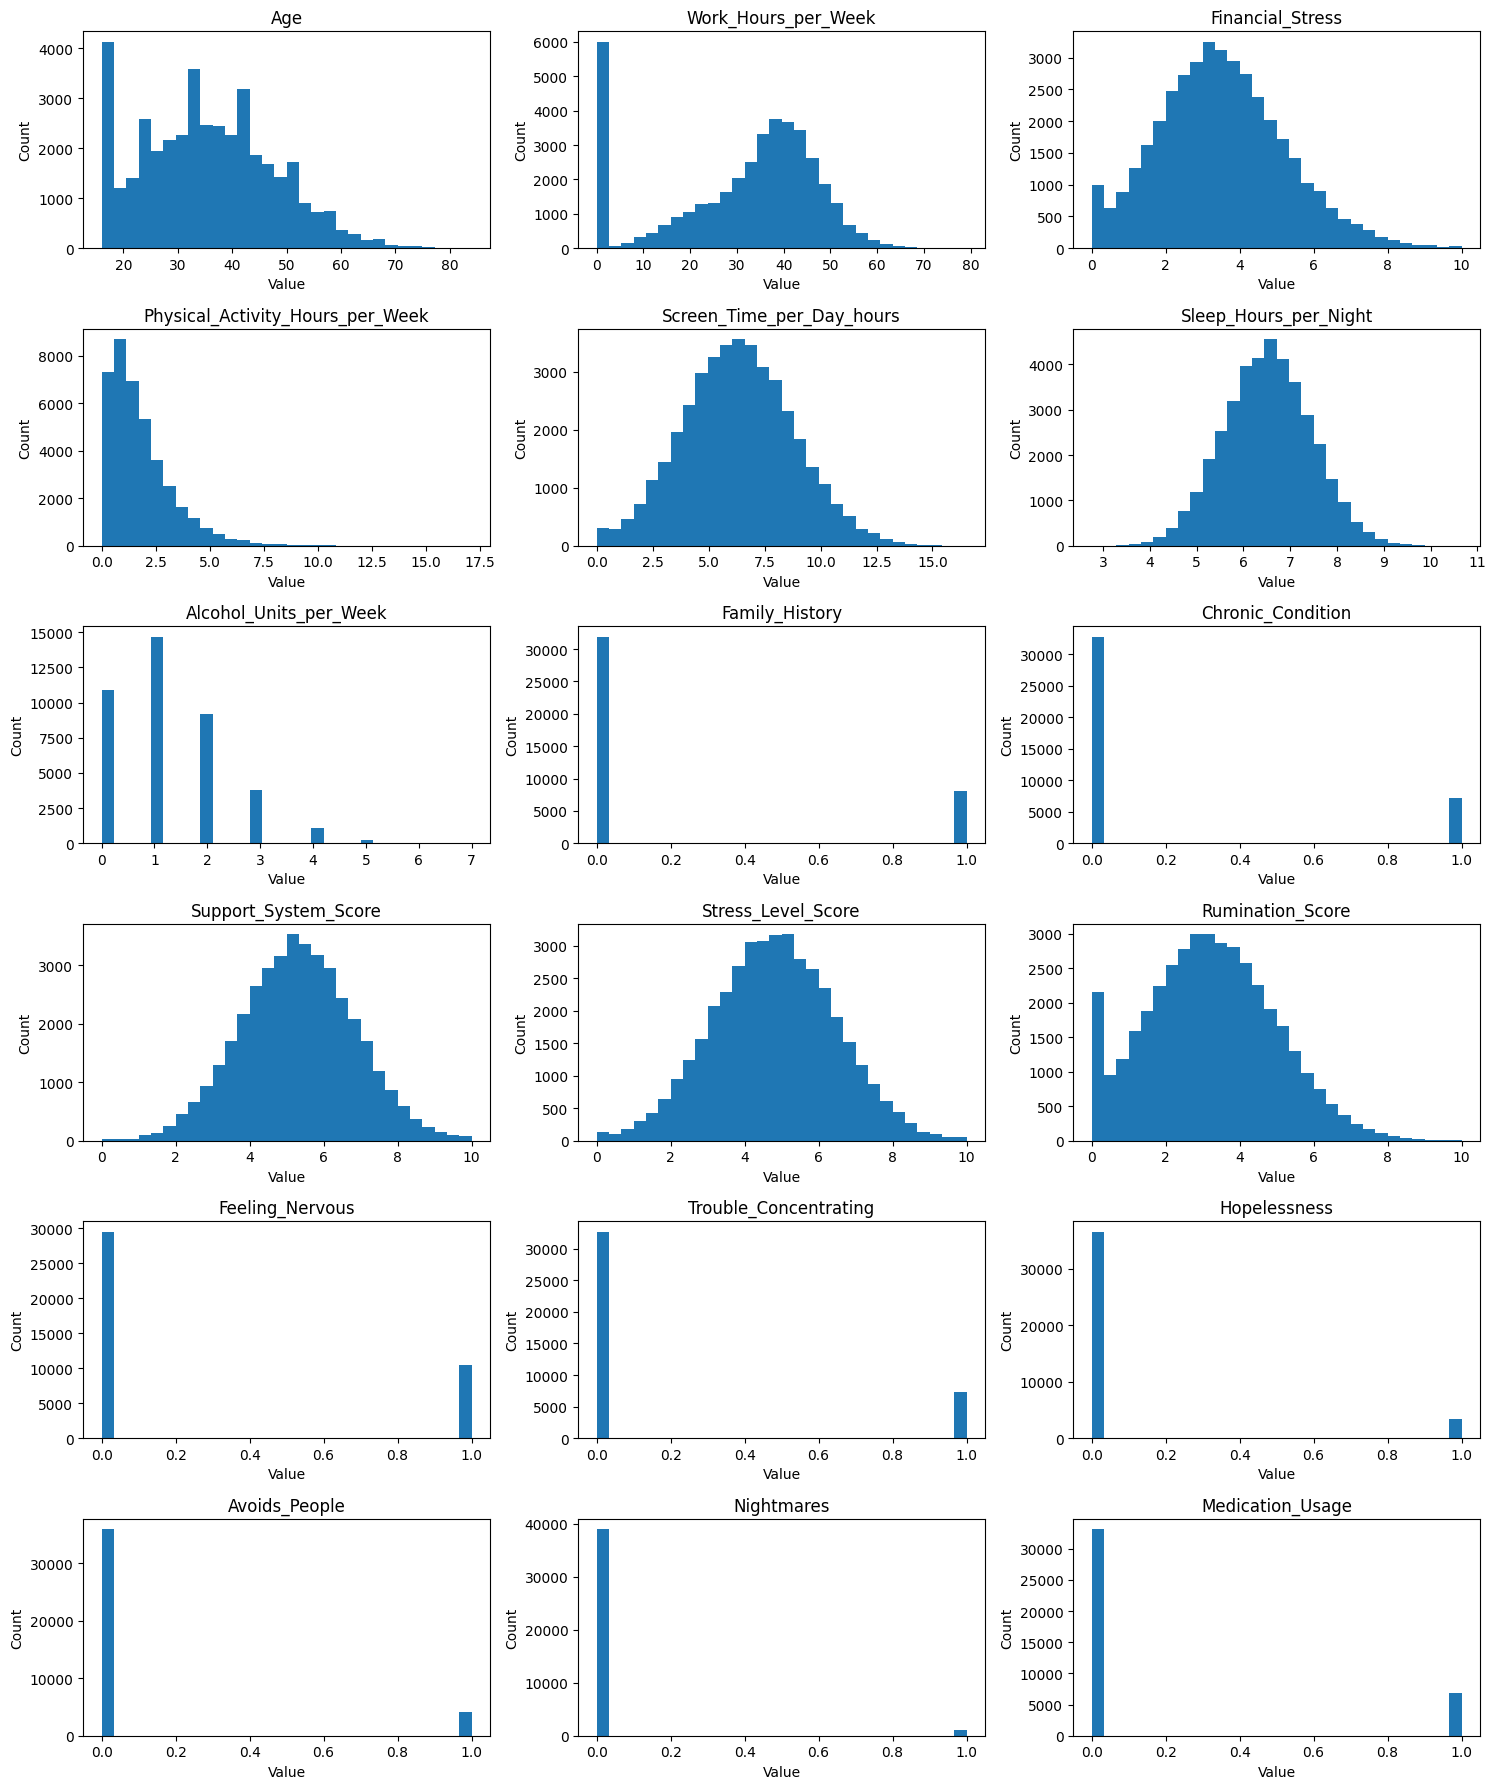

In [5]:
# Visualizations: histograms for numeric features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Plot histograms in a grid
n = len(num_cols)
cols = 3
rows = int(np.ceil(n/cols))
plt.figure(figsize=(5*cols, 3*rows))
for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    plt.hist(df[col].dropna(), bins=30)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

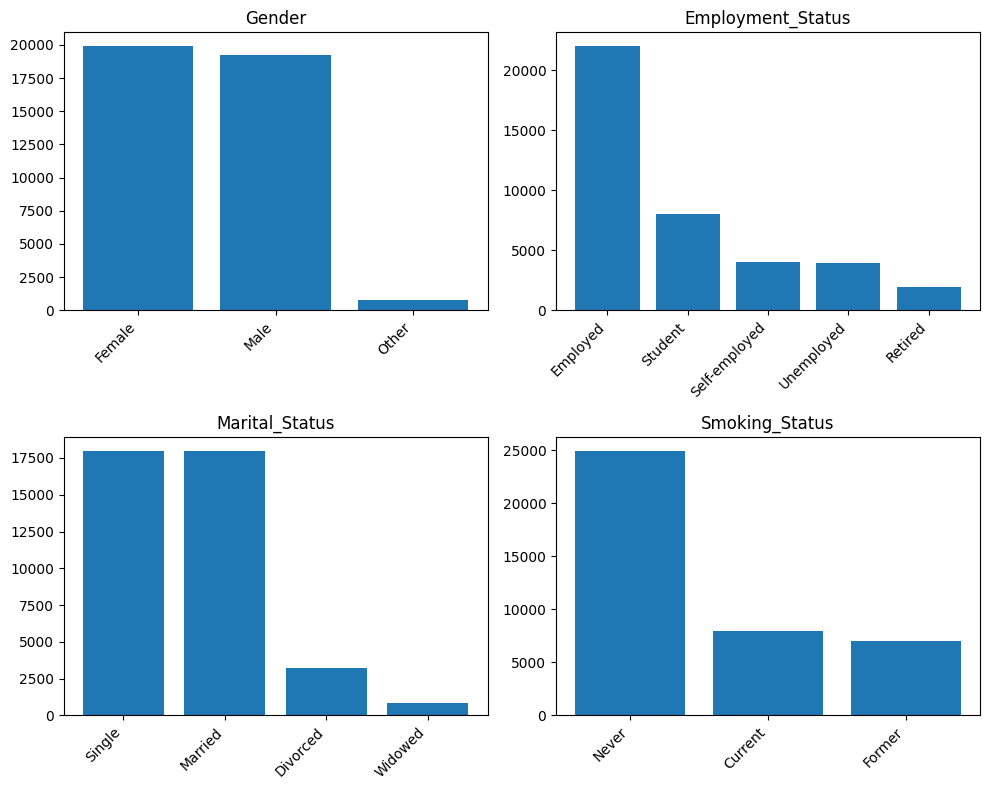

In [6]:
# Categorical distributions (counts) for key categorical features
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
# exclude target
cat_cols = [c for c in cat_cols if c!='Mental_Illness']

plt.figure(figsize=(5*2, 4*int(np.ceil(len(cat_cols)/2))))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(int(np.ceil(len(cat_cols)/2)), 2, i)
    vals = df[col].value_counts()
    plt.bar(vals.index.astype(str), vals.values)
    plt.title(col)
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Top correlations with target:
target_enc                   1.000000
Rumination_Score             0.541288
Stress_Level_Score           0.433075
Trouble_Concentrating        0.300223
Hopelessness                 0.274236
Feeling_Nervous              0.269142
Financial_Stress             0.258549
Medication_Usage             0.217287
Avoids_People                0.185675
Family_History               0.143265
Nightmares                   0.053367
Chronic_Condition            0.022741
Screen_Time_per_Day_hours    0.011040
Age                          0.002529
Alcohol_Units_per_Week      -0.002042
Name: target_enc, dtype: float64


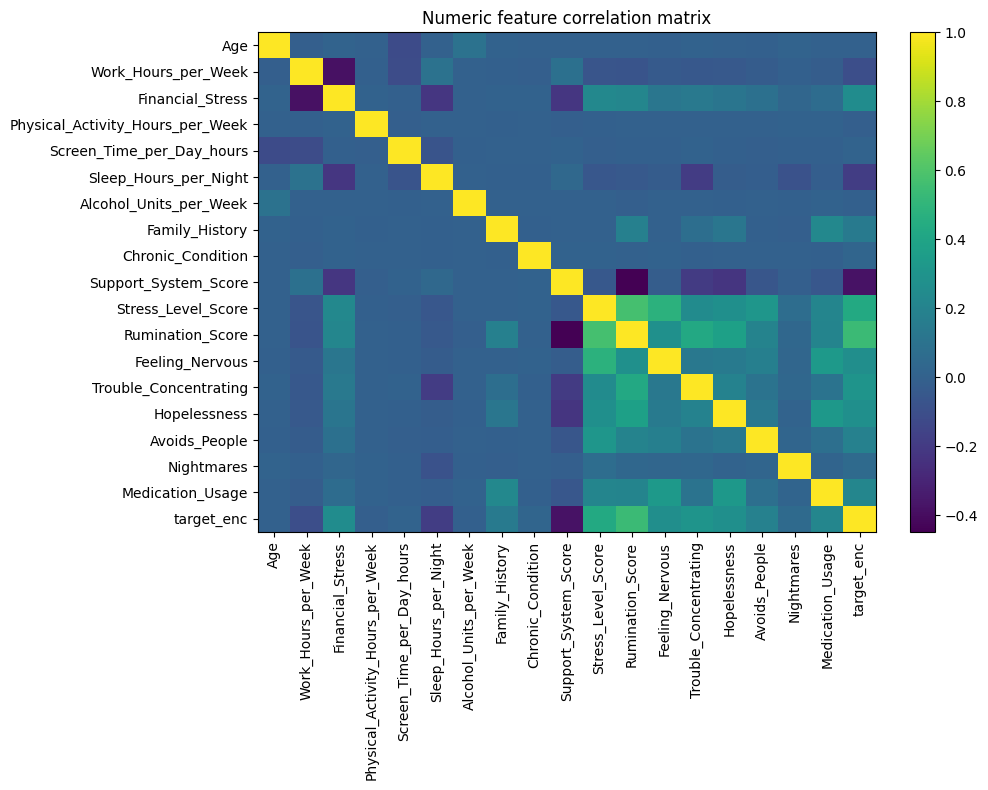

In [7]:
# Correlations: numeric features vs target (encoded) and correlation heatmap
# Encode target for correlation analysis
df_corr = df.copy()
df_corr['target_enc'] = (df_corr['Mental_Illness']=='Yes').astype(int)

num_cols = df_corr.select_dtypes(include=[np.number]).columns.tolist()
corr_with_target = df_corr[num_cols].corr()['target_enc'].sort_values(ascending=False)
print('Top correlations with target:')
print(corr_with_target.head(15))

# Heatmap for numeric correlations (matplotlib imshow)
corr_matrix = df_corr[num_cols].corr()
plt.figure(figsize=(10,8))
im = plt.imshow(corr_matrix, interpolation='nearest', aspect='auto')
plt.colorbar(im, fraction=0.04)
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title('Numeric feature correlation matrix')
plt.tight_layout()
plt.show()

In [8]:
# Preprocessing: imputation, encoding, scaling via ColumnTransformer
# Identify column types
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove target if present in numeric_features (shouldn't be)
numeric_features = [c for c in numeric_features if c!='target_enc']

categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = [c for c in categorical_features if c!='Mental_Illness']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

Numeric features: ['Age', 'Work_Hours_per_Week', 'Financial_Stress', 'Physical_Activity_Hours_per_Week', 'Screen_Time_per_Day_hours', 'Sleep_Hours_per_Night', 'Alcohol_Units_per_Week', 'Family_History', 'Chronic_Condition', 'Support_System_Score', 'Stress_Level_Score', 'Rumination_Score', 'Feeling_Nervous', 'Trouble_Concentrating', 'Hopelessness', 'Avoids_People', 'Nightmares', 'Medication_Usage']
Categorical features: ['Gender', 'Employment_Status', 'Marital_Status', 'Smoking_Status']


In [9]:
# Prepare X and y, stratified split
X = df.drop(columns=['Mental_Illness']).copy()
y = (df['Mental_Illness']=='Yes').astype(int)  # binary 1/0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (32000, 22) Test shape: (8000, 22)


In [10]:
# Define models and pipelines
models = {
    'LogisticRegression': Pipeline(steps=[('pre', preprocessor),
                                         ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))]),
    'RandomForest': Pipeline(steps=[('pre', preprocessor),
                                    ('clf', RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42))]),
    'GradientBoosting': Pipeline(steps=[('pre', preprocessor),
                                        ('clf', GradientBoostingClassifier(n_estimators=200, random_state=42))])
}

# Cross-validate models (StratifiedKFold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

cv_results = {}
for name, pipeline in models.items():
    print(f'Running CV for {name}...')
    res = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
    cv_results[name] = res
    print(name, 'ROC AUC (mean):', np.mean(res['test_roc_auc']))

# Summarize CV results
summary = []
for name, res in cv_results.items():
    summary.append({
        'model': name,
        'accuracy_mean': np.mean(res['test_accuracy']),
        'precision_mean': np.mean(res['test_precision']),
        'recall_mean': np.mean(res['test_recall']),
        'f1_mean': np.mean(res['test_f1']),
        'roc_auc_mean': np.mean(res['test_roc_auc'])
    })
pd.DataFrame(summary).set_index('model')

Running CV for LogisticRegression...
LogisticRegression ROC AUC (mean): 0.8784852546607833
Running CV for RandomForest...
RandomForest ROC AUC (mean): 0.875176423309812
Running CV for GradientBoosting...
GradientBoosting ROC AUC (mean): 0.880946106656236


,accuracy_mean,precision_mean,recall_mean,f1_mean,roc_auc_mean
model,,,,,
LogisticRegression,0.797375,0.762801,0.788976,0.775660,0.878485
RandomForest,0.800563,0.795099,0.742028,0.767643,0.875176
GradientBoosting,0.803594,0.795515,0.750615,0.772396,0.880946


Best model by CV ROC AUC: GradientBoosting

Test set classification report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      4448
           1       0.80      0.76      0.78      3552

    accuracy                           0.81      8000
   macro avg       0.81      0.80      0.80      8000
weighted avg       0.81      0.81      0.81      8000


Test ROC AUC: 0.8847873348280835


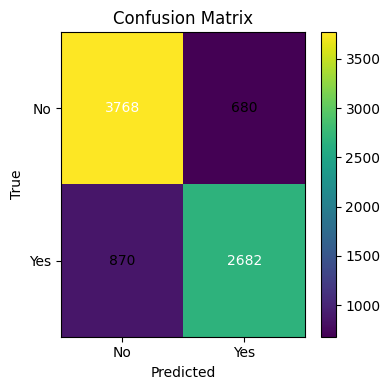

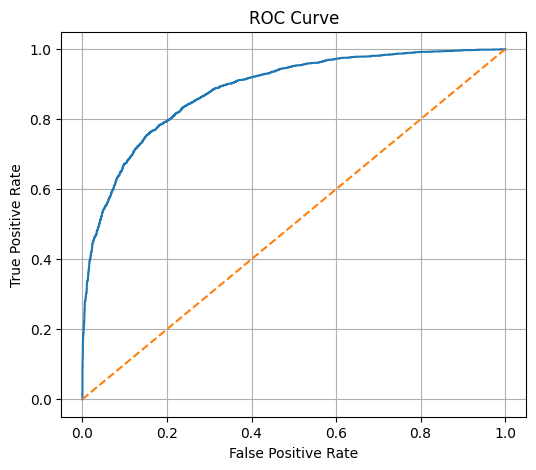

In [11]:
# Fit the chosen model on full training data and evaluate on test set
# Choose best by ROC AUC from CV
best_model_name = max(cv_results.keys(), key=lambda n: np.mean(cv_results[n]['test_roc_auc']))
print('Best model by CV ROC AUC:', best_model_name)

best_pipeline = models[best_model_name]
best_pipeline.fit(X_train, y_train)

# Predictions
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:,1]

print('\nTest set classification report:')
print(classification_report(y_test, y_pred))

print('\nTest ROC AUC:', roc_auc_score(y_test, y_proba))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0,1], ['No','Yes'])
plt.yticks([0,1], ['No','Yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, int(val), ha='center', va='center', color='white' if val>cm.max()/2 else 'black')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

In [13]:
from sklearn.inspection import permutation_importance

# Extract model and preprocessor
preprocessor = best_pipeline.named_steps['pre']
model = best_pipeline.named_steps['clf']

# Transform test set manually
X_test_transformed = preprocessor.transform(X_test)

# Build correct feature names
num_feats = numeric_features

# Handle categorical one-hot names correctly
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
if hasattr(ohe, 'get_feature_names_out'):
    cat_feats = ohe.get_feature_names_out(categorical_features).tolist()
else:
    cat_feats = ohe.get_feature_names(categorical_features).tolist()

feature_names = num_feats + cat_feats

# Compute permutation importance directly on the transformed data
r = permutation_importance(model, X_test_transformed, y_test, n_repeats=20, random_state=42, n_jobs=-1)

# Build DataFrame safely
imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': r.importances_mean,
    'importance_std': r.importances_std
}).sort_values('importance_mean', ascending=False).reset_index(drop=True)

imp_df.head(20)


,feature,importance_mean,importance_std
0,Support_System_Score,0.061156,0.002968
1,Rumination_Score,0.057300,0.003409
2,Stress_Level_Score,0.043138,0.002646
3,Sleep_Hours_per_Night,0.025513,0.002549
4,Family_History,0.005800,0.001824
5,Financial_Stress,0.005200,0.001582
6,Medication_Usage,0.003856,0.000964
7,Hopelessness,0.003425,0.000787
8,Avoids_People,0.002550,0.000873
9,Trouble_Concentrating,0.002075,0.001223


In [14]:
# Save preprocessor and model separately for deployment
import joblib
import os

# Create a directory to store models if it doesn't exist
model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Save the preprocessor
preprocessor_path = os.path.join(model_dir, 'preprocessor.pkl')
joblib.dump(preprocessor, preprocessor_path)
print(f'Saved preprocessor to {preprocessor_path}')

# Save the model (classifier only)
model_path = os.path.join(model_dir, 'classifier_model.pkl')
joblib.dump(model, model_path)
print(f'Saved classifier model to {model_path}')

# Save the full pipeline (preprocessor + classifier together)
pipeline_path = os.path.join(model_dir, 'full_pipeline.pkl')
joblib.dump(best_pipeline, pipeline_path)
print(f'Saved full pipeline to {pipeline_path}')

# Also save feature importance results
imp_df.to_csv(os.path.join(model_dir, 'feature_importance.csv'), index=False)
print(f'Saved feature importance to {model_dir}/feature_importance.csv')


Saved preprocessor to saved_models\preprocessor.pkl
Saved classifier model to saved_models\classifier_model.pkl
Saved full pipeline to saved_models\full_pipeline.pkl
Saved feature importance to saved_models/feature_importance.csv


## Next steps & expert recommendations

- **Hyperparameter tuning**: Use GridSearchCV or RandomizedSearchCV on the chosen model (or use Optuna) to improve performance.
- **Calibration**: Check probability calibration (CalibratedClassifierCV) if you will use predicted probabilities for decisions.
- **Class imbalance strategies**: Try over/under-sampling (SMOTE, ADASYN) or stronger class weights, depending on target prevalence.
- **Explainability**: Use SHAP or LIME for per-sample explanations (install packages as needed).
- **Temporal validation**: If the data will be collected over time, validate models on future time slices to ensure generalization.
